# Churn Problem for Bank Customer

## Can you develop a machine learning model that can predict the customers who will leave the company?

- The aim is to estimate whether a bank's customers leave the bank or not.

- The event that defines the customer abandonment is the closing of the customer's bank account.

### Data Set Story:

- It consists of 10000 observations and 12 variables.
- Independent variables contain information about customers.
- Dependent variable refers to customer abandonment.

### Features:

- Surname: Surname
- CreditScore: Credit score
- Geography: Country (Germany / France / Spain)
- Gender: Gender (Female / Male)
- Age: Age
- Tenure: How many years of customer
- Balance: Balance
- NumOfProducts: Bank product used
- HasCrCard: Credit card status (0 = No, 1 = Yes)
- IsActiveMember: Active membership status (0 = No, 1 = Yes)
- EstimatedSalary: Estimated salary
- Exited: Abandoned or not? (0 = No, 1 = Yes)

## 1. Installing

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression  
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, GridSearchCV,train_test_split,cross_val_score
import itertools
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import LocalOutlierFactor # çok değişkenli aykırı gözlem incelemesi
from sklearn.preprocessing import scale,StandardScaler, MinMaxScaler,Normalizer,RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import  accuracy_score, f1_score, precision_score,confusion_matrix, recall_score, roc_auc_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier


import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 

%config InlineBackend.figure_format = 'retina'

# to display all columns and rows:
pd.set_option('display.max_columns', None); pd.set_option('display.max_rows', None);  # to display all columns and rows
pd.set_option('display.float_format', lambda x: '%.2f' % x) # The number of numbers that will be shown after the comma.


df = pd.read_csv("churn.csv", index_col=0)
df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## 2. EDA (Exploratory of Data Analysis)
### 2.1. Data Preperation

In [2]:
dependent_variable_name = "Exited"

In [3]:
def data_prepare():
    df_prep = df.copy()
    
    
    missing_value_len = df.isnull().any().sum()
    if missing_value_len == 0:
        print("No Missing Value")
    else:
        print("Investigate Missing Value, Missing Value : " + str(missing_value_len))
    print("\n")
    
    show_unique_count_variables(df = df_prep)
    
    
    df_prep['Tenure'] =  df_prep.Tenure.astype(np.float)
    df_prep['NumOfProducts'] =  df_prep.NumOfProducts.astype(np.float)
    return df_prep


Unique value data representation on all variables:

In [4]:
def show_unique_count_variables(df):
    for index, value in df.nunique().items():
        print(str(index) + "\n\t\t\t:" + str(value))

### 2.2. Outliers Observe (LOF method and Supress)
#### 2.2.1. Outlier Editing

In [5]:

def show_outliers(df):
    
    #tüm sütünları yukardan bakarak  outlier feature'ları gözlemleme
    
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    df_num_cols = df.select_dtypes(include=numerics)
    sns.set(font_scale = 0.7) 
    fig, axes = plt.subplots(nrows = 2, ncols = 5, gridspec_kw =  dict(hspace=0.3), figsize = (12,9))
    fig.tight_layout()
    for ax,col in zip(axes.flatten(), df_num_cols.columns):
        sns.boxplot(x = df_num_cols[col], color='green', ax = ax)
    fig.suptitle('Observing Outliers', color = 'r', fontsize = 14)

#### 2.2.2. Visualization of outliers according to the LOF method

In [6]:

def lof_observation(df):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    df_num_cols = df.select_dtypes(include=numerics)
    df_outlier = df_num_cols.astype("float64")
    clf = LocalOutlierFactor(n_neighbors = 20, contamination = 0.1)
    clf.fit_predict(df_outlier)
    df_scores = clf.negative_outlier_factor_
    scores_df = pd.DataFrame(np.sort(df_scores))
    
    scores_df.plot(stacked=True, xlim = [0,20], color='r', title='Visualization of outliers according to the LOF method', style = '.-');                # first 20 observe
    th_val = np.sort(df_scores)[2]
    outliers = df_scores > th_val
    df = df.drop(df_outlier[~outliers].index)
    df.shape
    return df

#### 2.2.3. Outiler suppression

In [7]:

def clear_outliers(df):
    
    #yas ve kredi_skoru baskılama
    
    Q1 = df["Age"].quantile(0.25)
    Q3 = df["Age"].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    print("When age and credit score is printed below lower score: ", lower, "and upper score: ", upper)
    df_outlier = df["Age"][(df["Age"] > upper)]
    df["Age"][df_outlier.index] = upper
    
    
    #kredi_skoru
    
    Q1 = df["CreditScore"].quantile(0.25)
    Q3 = df["CreditScore"].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    print("When age and credit score is printed above lower score: ", lower, "and upper score: ", upper)
    df_outlier = df["CreditScore"][(df["CreditScore"] < lower)]
    df["CreditScore"][df_outlier.index] = lower
    
    return df

#### 2.2.4. Outiler Process

In [8]:

def outlier_process(df):
    #show_outliers(df = df)
    df_outlier = lof_observation(df = df)
    df_outlier = clear_outliers(df = df_outlier)
    return df_outlier

### 2.3. Data Analysis
#### 2.3.1. Dependent variable distribution

In [9]:

def show_dependent_variable(df):
#     sns.countplot(data = df, x = dependent_variable_name, label = 'Count') \
#     .set_title(dependent_variable_name + ' dependent variable situation', fontsize = 18, color = 'r')
    fig, axarr = plt.subplots(2, 3, figsize=(18, 6))
    sns.countplot(x = 'Geography', hue = 'Exited',data = df, ax = axarr[0][0])
    sns.countplot(x = 'Gender', hue = 'Exited',data = df, ax = axarr[0][1])
    sns.countplot(x = 'HasCrCard', hue = 'Exited',data = df, ax = axarr[0][2])
    sns.countplot(x = 'IsActiveMember', hue = 'Exited',data = df, ax = axarr[1][0])
    sns.countplot(x = 'NumOfProducts', hue = 'Exited',data = df, ax = axarr[1][1])
    sns.countplot(x = 'Tenure', hue = 'Exited',data = df, ax = axarr[1][2])
    zero, one = df[dependent_variable_name].value_counts()
    print("Dependent variable distribution;")
    print(dependent_variable_name + " 0 count:", zero)
    print(dependent_variable_name + " 1 count:", one)

#### 2.3.2. Numeric columns distribution observation

In [10]:

def show_numeric_columns_distributions(df):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    df_num_cols = df.select_dtypes(include=numerics)
    columns = df_num_cols.columns[: len(df_num_cols.columns)]
    fig = plt.figure()
    fig.set_size_inches(18, 15)
    #plt.subplots(figsize=(22,22))
    length = len(columns)
    for i,j in itertools.zip_longest(columns, range(length)):
        plt.subplot((length / 2), 3, j+1)
        plt.subplots_adjust(wspace = 0.2, hspace = 0.5)
        df_num_cols[i].hist(bins = 20, edgecolor = 'black')
        plt.title(i)
    fig = fig.suptitle('Structures of numeric variables', color = 'r' ,fontsize = 18)
    plt.show()

#### 2.3.3. Status of other variables according to dependent variable

In [11]:

def show_dependent_variable_cross_others_distributions(df):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    df_dependent_var = df[df[dependent_variable_name] == 1]
    df_num_cols = df_dependent_var.select_dtypes(include = numerics)
    columns = df_num_cols.columns[: len(df_num_cols.columns)]
    
    fig = plt.figure()
    fig.set_size_inches(18, 15)
    length = len(columns)
    for i,j in itertools.zip_longest(columns, range(length)):
        plt.subplot((length / 2), 3, j+1)
        plt.subplots_adjust(wspace = 0.2, hspace = 0.5)
        df_num_cols[i].hist(bins = 20, edgecolor = 'black')
        plt.title(i)
    fig = fig.suptitle(dependent_variable_name + ' Status of other variables according to 1 dependent variable', color = 'r', fontsize = 18)
    plt.show()

#### 2.3.4. Categorical variables are observed according to the dependent variable

In [12]:

def show_dependent_variable_cross_categorical_distributions(df, categorical_columns):
    sns.set(font_scale = 0.7) 
    fig, axes = plt.subplots(nrows = int( len(categorical_columns) / 2 ) , ncols = 2, figsize = (7,9))
    fig.tight_layout()
    for ax,col in zip(axes.flatten(), categorical_columns):
        sns.countplot(x = df[col], hue = dependent_variable_name, data = df, ax = ax)
    fig.suptitle('Categorical variables are monitored according to the dependent variable', color = 'r', fontsize = 1)
  

#### 2.3.5. The main method that started all data analysis

In [13]:
def show_data_analysis(df):
    show_dependent_variable(df)
    show_numeric_columns_distributions(df)
    show_dependent_variable_cross_others_distributions(df)
    show_dependent_variable_cross_categorical_distributions(df = df_outlier, categorical_columns = ["Gender","Geography","HasCrCard","IsActiveMember"])


## 3. Feature Engineering
### 3.1. Credit Score grouping ( min= 358 and max= 800)

In [14]:

def credit_score_table(row):
    
    credit_score = row.CreditScore
    if credit_score >= 300 and credit_score < 500:
        return "Very_Poor"
    elif credit_score >= 500 and credit_score < 601:
        return "Poor"
    elif credit_score >= 601 and credit_score < 661:
        return "Fair"
    elif credit_score >= 661 and credit_score < 781:
        return "Good"
    elif credit_score >= 851:
        return "Top"
    elif credit_score >= 781 and credit_score < 851:
        return "Excellent"
    elif credit_score < 300:
        return "Deep"

### 3.2. Product utilization RATE by YEAR

In [15]:

def product_utilization_rate_by_year(row):
    number_of_products = row.NumOfProducts
    tenure = row.Tenure
    
    if number_of_products == 0:
        return 0
    
    if tenure == 0:
        return number_of_products
    
    rate = number_of_products / tenure
    return rate

### 3.3. Product utilization rate by estimated SALARY

In [16]:

def product_utilization_rate_by_estimated_salary(row):
    number_of_products = row.number_of_products
    estimated_salary = row.EstimatedSalary
    
    if number_of_products == 0:
        return 0

    
    rate = number_of_products / estimated_salary
    return rate

### 3.4. According to countries monthly average salaries

In [17]:

def countries_monthly_average_salaries(row):
    #brutto datas from  https://tr.wikipedia.org/wiki/Aylık_ortalama_ücretlerine_göre_Avrupa_ülkeleri_listesi
    fr = 3696    
    de = 4740
    sp = 2257
    salary = row.EstimatedSalary / 12
    country = row.Geography              # Germany, France and Spain
    
    if country == 'Germany':
        return salary / de
    elif country == "France":
        return salary / fr
    elif country == "Spain": 
        return salary / sp

### 3.5. The main method that started all Feature Engineering

In [18]:
def feature_engineering(df, is_show_graph = False):
    df_fe = df.copy()
    
    #bakiye_maas_orani
    balance_salary_rate = 'balance_salary_rate'
    df_fe[balance_salary_rate] = df_fe.Balance / df_fe.EstimatedSalary
    
    #yila_gore_urun_kullanim_orani
    df_fe = df_fe.assign(product_utilization_rate_by_year=df_fe.apply(lambda x: product_utilization_rate_by_year(x), axis=1)) 
    
    #tahmini_maasa_gore_urun_kullanim_orani
    #df_fe = df_fe.assign(product_utilization_rate_by_estimated_salary = df_fe.apply(lambda x: product_utilization_rate_by_estimated_salary(x), axis=1)) 
    
    
    #musteri_yilina göre yaşa göre standardize edilmesi, oranlanmasi - ergenlik donemini cikariyoruz!
    tenure_rate_by_age = 'tenure_rate_by_age'
    df_fe[tenure_rate_by_age] = df_fe.Tenure / (df_fe.Age-17)
    
    #yaşa göre kredi_skoru standardize edilmesi, oranlanmasi - ergenlik donemini cikariyoruz!
    credit_score_rate_by_age = 'credit_score_rate_by_age'
    df_fe[credit_score_rate_by_age] = df_fe.CreditScore / (df_fe.Age-17)
    
    #maaşa gore kullanilan urun oran, oranlanmasi
    product_utilization_rate_by_salary = 'product_utilization_rate_by_salary'
    #df_fe[product_utilization_rate_by_salary] = df_fe.Tenure / (df_fe.EstimatedSalary)
   
    #maaşa göre kredi_skoru urun oran, oranlanmasi
    credit_score_rate_by_salary = 'credit_score_rate_by_salary'
    df_fe[credit_score_rate_by_salary] = df_fe.CreditScore / (df_fe.EstimatedSalary)
    
    #Feature Eng. oluşturulan değişkenlerin bağımlı değişkene göre grafikleri gösterilsin mi?
    if is_show_graph:
        fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (20,12))
        fig.tight_layout()
        sns.boxplot(y = balance_salary_rate, x = dependent_variable_name, hue = dependent_variable_name, data = df_fe, ax = axes[0][0])
        sns.boxplot(y = product_utilization_rate_by_year, x = dependent_variable_name, hue = dependent_variable_name, data = df_fe, ax = axes[0][1])
        #sns.countplot(x = credit_score_rate_by_age, hue = dependent_variable_name, data = df_fe, ax = axes[1][0])
        #sns.countplot(x = credit_score_rate_by_age, hue = dependent_variable_name, data = df_fe, ax = axes[1][1])
        plt.ylim(-1, 5)
    
    
    #feature engineering add- kredi_skor_tablosu
    df_fe = df_fe.assign(credit_score_table=df_fe.apply(lambda x: credit_score_table(x), axis=1))
    
    #feature engineering add- ulkelere ortalama  maas durum
    df_fe = df_fe.assign(countries_monthly_average_salaries = df_fe.apply(lambda x: countries_monthly_average_salaries(x), axis=1)) 
    
    return df_fe

## 4. Data Encoding

In [19]:
# vucut_yag_orani, vucut_yag_orani_kategori,beden_kitle_kategori,insulin_kategori,kucuk_tansiyon_kategori

def data_encoding(df):
    df_model = df.copy()
    '''
    # It was attempted to reduce the number of 0 observations.
    churn_zero = df_model[df_model.apply(lambda x: True if x['Exited'] == 0 else False , axis=1)]
    df_train = churn_zero.sample(frac=0.1,random_state=100)
    df_model = df_model.drop(df_train.index)
    '''
    
    
    # >>>> Categorical columns <<<<<
    
    non_encoding_columns = ["Geography","HasCrCard","IsActiveMember","Gender","NumOfProducts","Tenure","credit_score_table"]
    
    df_non_encoding = df_model[non_encoding_columns]
    df_model = df_model.drop(non_encoding_columns,axis=1)
    
    
    df_encoding = df_non_encoding.copy()
    
    from sklearn.preprocessing import LabelEncoder
    encoder = LabelEncoder()
    df_encoding["gender_category"] = encoder.fit_transform(df_non_encoding.Gender)
    df_encoding["country_category"] = encoder.fit_transform(df_non_encoding.Geography)
    df_encoding["credit_score_category"] = encoder.fit_transform(df_non_encoding.credit_score_table)

    

    df_encoding.reset_index(drop=True, inplace=True)
    df_model.reset_index(drop=True, inplace=True)
    df_model = pd.concat([df_model,df_encoding],axis=1)

    df_model = df_model.drop(["Geography","Gender","CustomerId","Surname","credit_score_table","CreditScore","EstimatedSalary"],axis=1)
    df_model = df_model.reset_index()
    df_model = df_model.drop('index',axis=1)
    
    df_model.loc[df_model.HasCrCard == 0, 'credit_card_situation'] = -1
    df_model.loc[df_model.IsActiveMember == 0, 'is_active_member'] = -1
    return df_model


## 5. Model Preparation

In [20]:
def model_prepare(df_model):
    y = df_model[dependent_variable_name]
    X = df_model.loc[:, df_model.columns != dependent_variable_name]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 12345)
    from sklearn.preprocessing import StandardScaler
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform (X_test)
    return X_train, X_test, y_train, y_test

### 5.1 Part of Data TRAIN

In [21]:
def data_training(X_train, X_test, y_train, y_test):

    models = []
    models.append(('LOGR',LogisticRegression()))
    models.append(('KNN',KNeighborsClassifier()))
    models.append(('CART',DecisionTreeClassifier()))
    models.append(('RF',RandomForestClassifier()))
    #models.append(('SVC',SVC()))
    models.append(('GBM',GradientBoostingClassifier()))
    models.append(('XGBoost',XGBClassifier()))
    models.append(('LightGBM',LGBMClassifier()))
    models.append(('CatBoost',CatBoostClassifier()))

    df_result = pd.DataFrame(columns=["model","accuracy_score","scale_method","0_precision","0_recall","1_precision","1_recall"])
    index = 0
    for name,model in models:
        model.fit(X_train,y_train)
        y_pred = model.predict(X_test)
        score = accuracy_score(y_test,y_pred)
        class_report = classification_report(y_test,y_pred,digits=2,output_dict=True)
        zero_report = class_report['0']
        one_report = class_report['1']
        df_result.at[index,['model','accuracy_score','scale_method',"0_precision","0_recall","1_precision","1_recall"]] = [name,score,"NA",zero_report['precision'],zero_report['recall'],one_report['precision'],one_report['recall']]
        index += 1
    return df_result.sort_values("accuracy_score",ascending=False)

## 6. HELPing Functions

In [22]:
# Function to give best model score and parameters

def best_model(model):
    print(model.best_score_)    
    print(model.best_params_)
    print(model.best_estimator_)
    
def get_auc_scores(y_actual, method,method2):
    auc_score = roc_auc_score(y_actual, method); 
    fpr_df, tpr_df, _ = roc_curve(y_actual, method2); 
    return (auc_score, fpr_df, tpr_df)


from matplotlib import rc,rcParams
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.rcParams.update({'font.size': 16})
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, color="blue")
    plt.yticks(tick_marks, classes, color="blue")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="red" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

''' inf yakalama
indices_to_keep = df_encoded.isin([np.nan, np.inf, -np.inf]).any(1)
df_encoded[indices_to_keep].astype(np.float64)
'''

' inf yakalama\nindices_to_keep = df_encoded.isin([np.nan, np.inf, -np.inf]).any(1)\ndf_encoded[indices_to_keep].astype(np.float64)\n'

## 7. Data Cleaning

No Missing Value


CustomerId
			:10000
Surname
			:2932
CreditScore
			:460
Geography
			:3
Gender
			:2
Age
			:70
Tenure
			:11
Balance
			:6382
NumOfProducts
			:4
HasCrCard
			:2
IsActiveMember
			:2
EstimatedSalary
			:9999
Exited
			:2
When age and credit score is printed below lower score:  14.0 and upper score:  62.0
When age and credit score is printed above lower score:  383.0 and upper score:  919.0


C:\Users\gebruiker\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\gebruiker\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Dependent variable distribution;
Exited 0 count: 7963
Exited 1 count: 2037


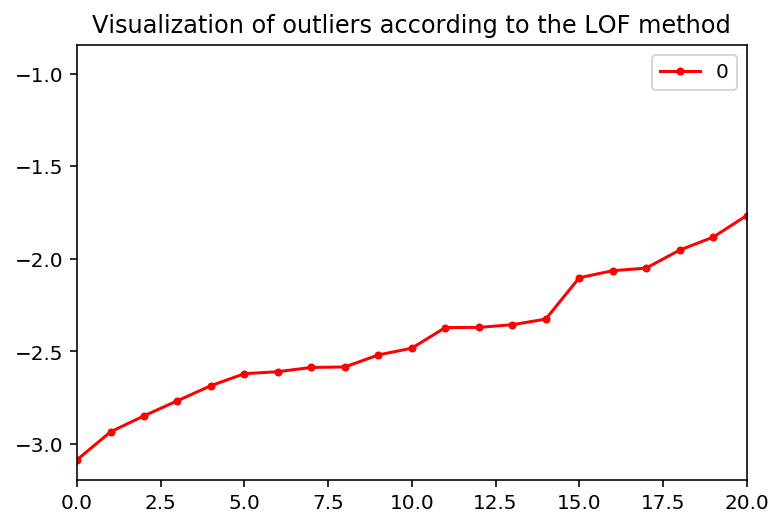

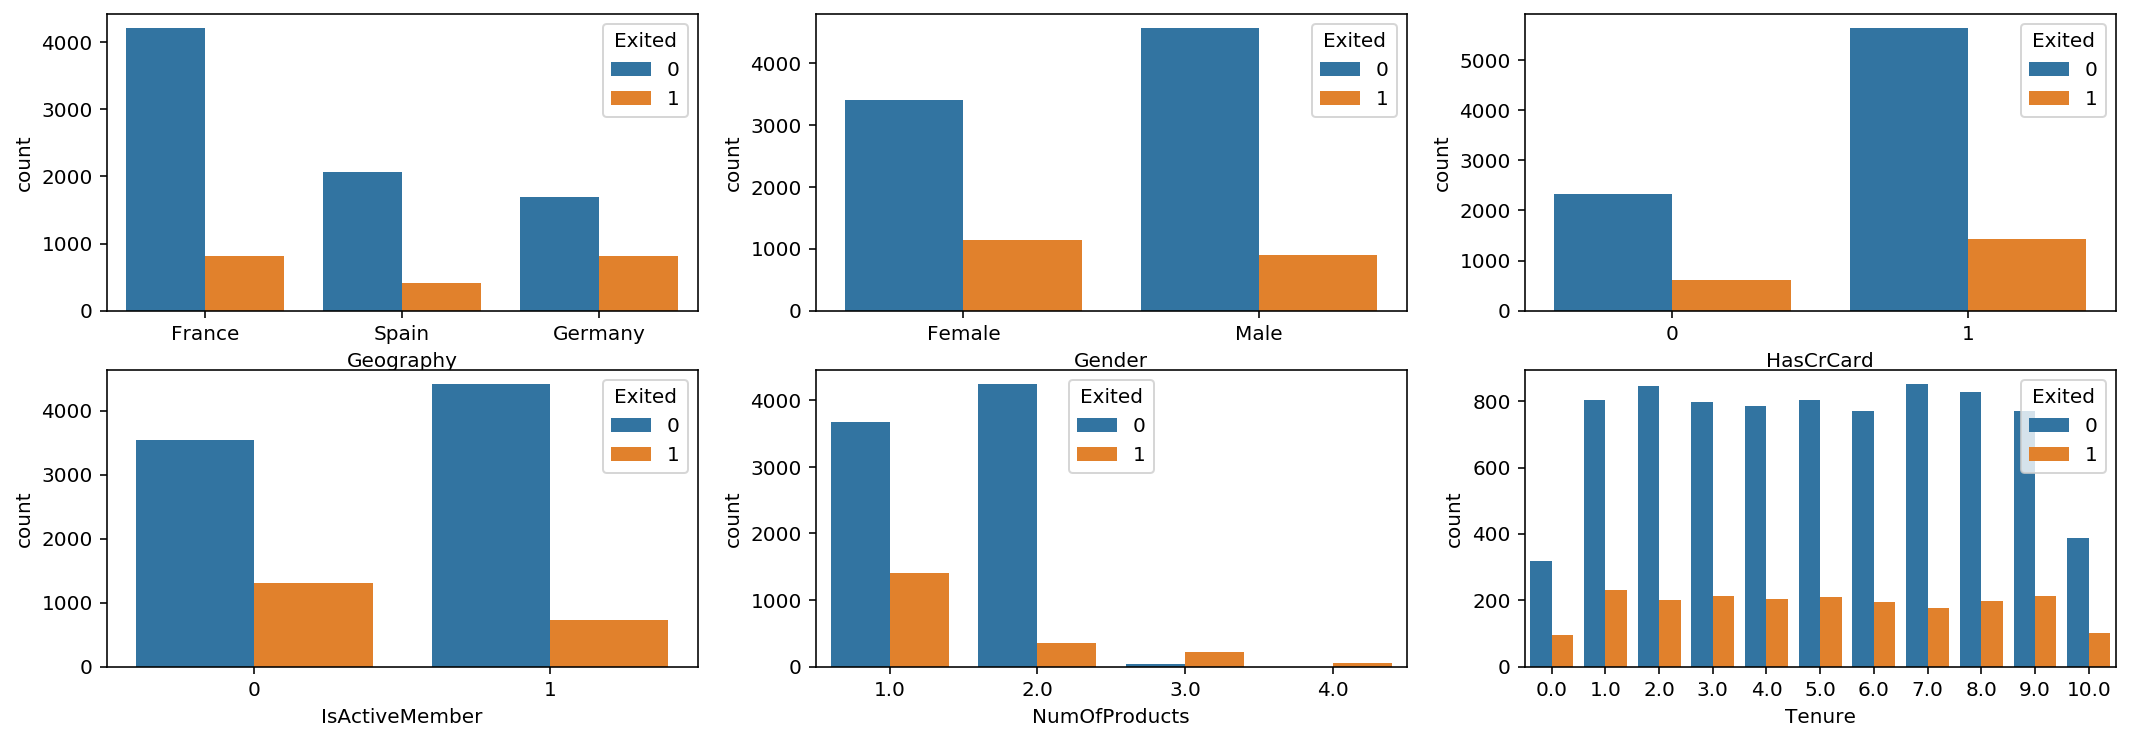

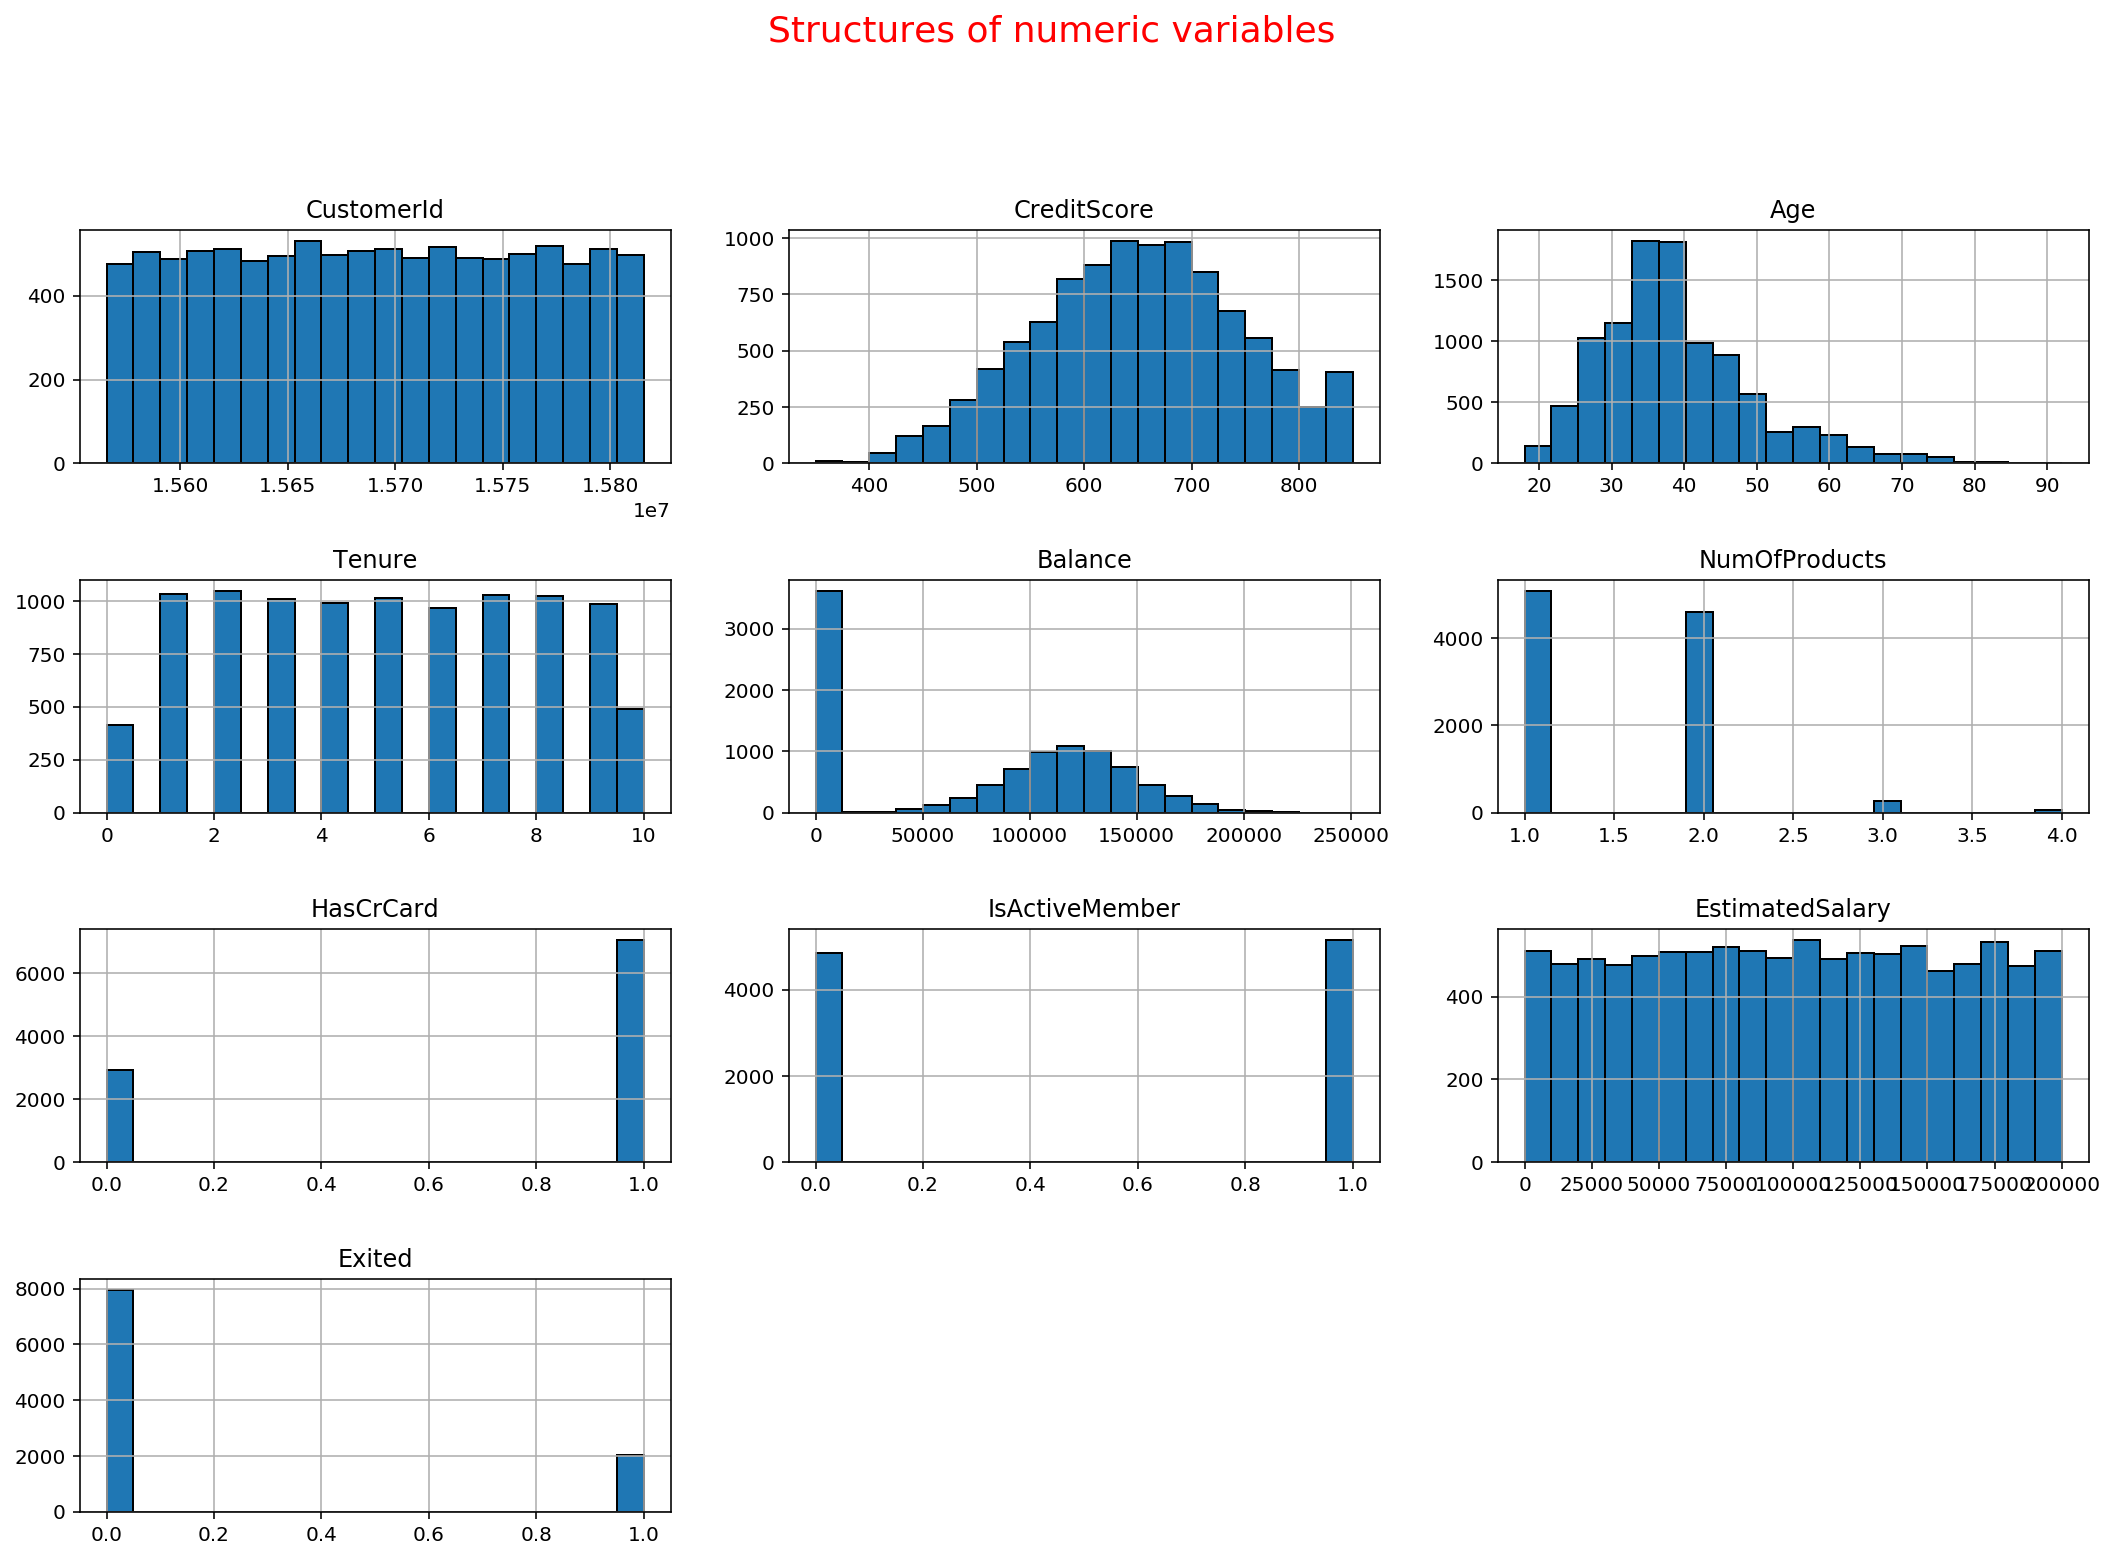

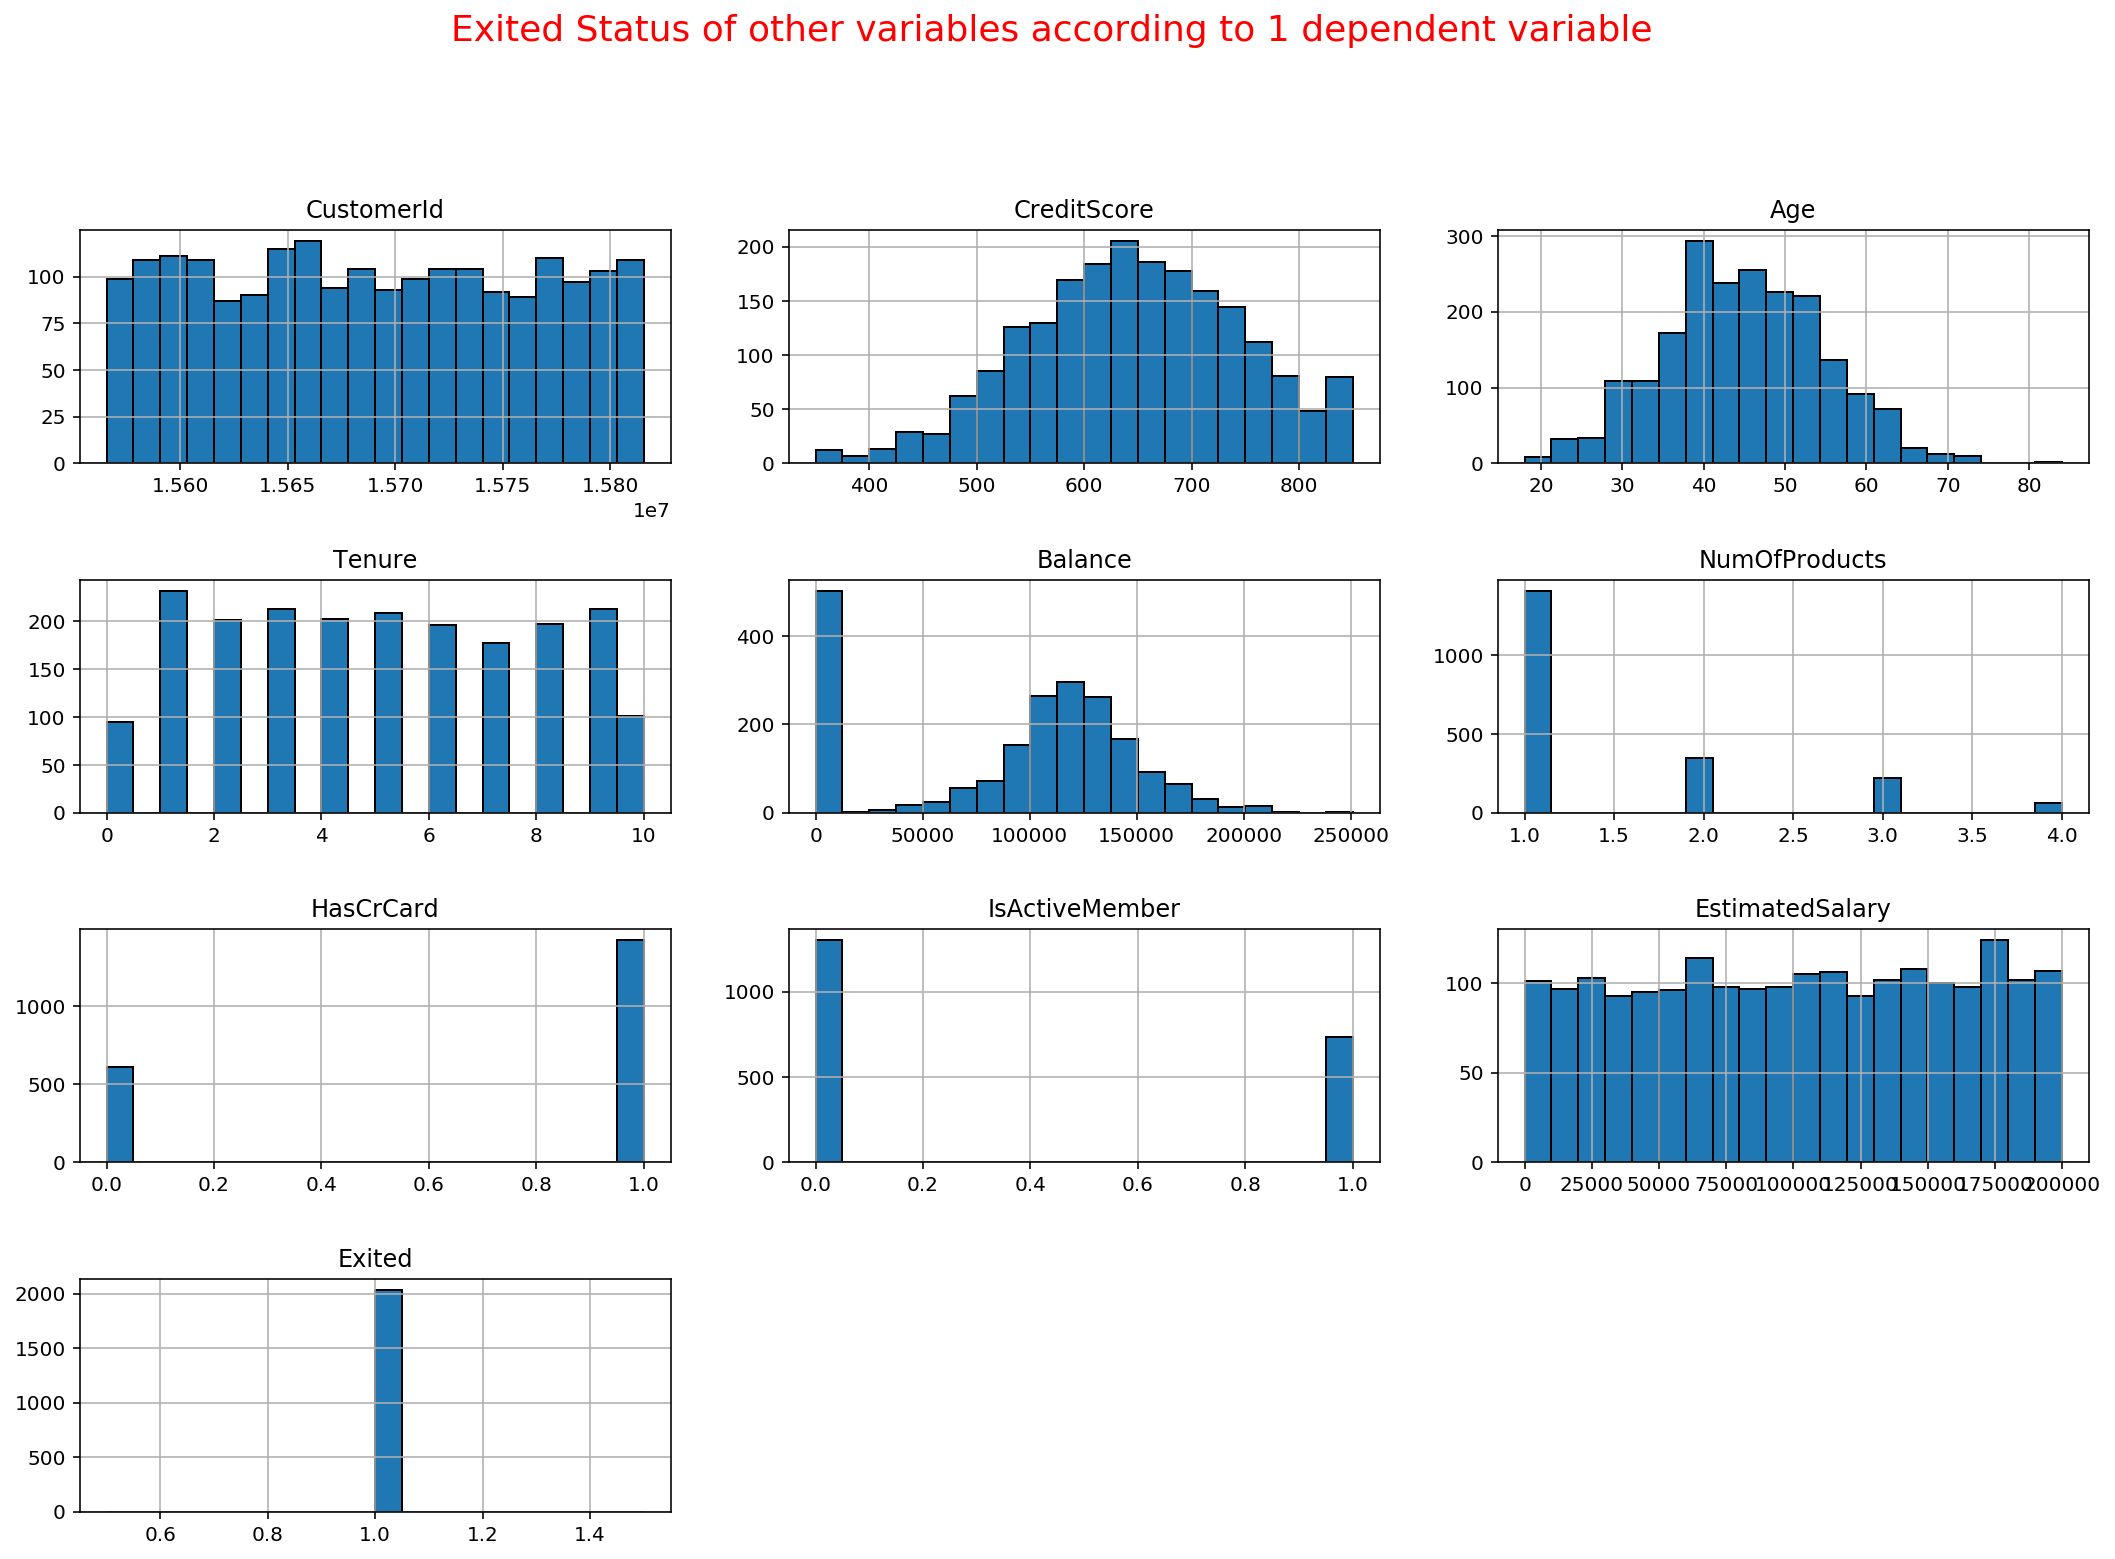

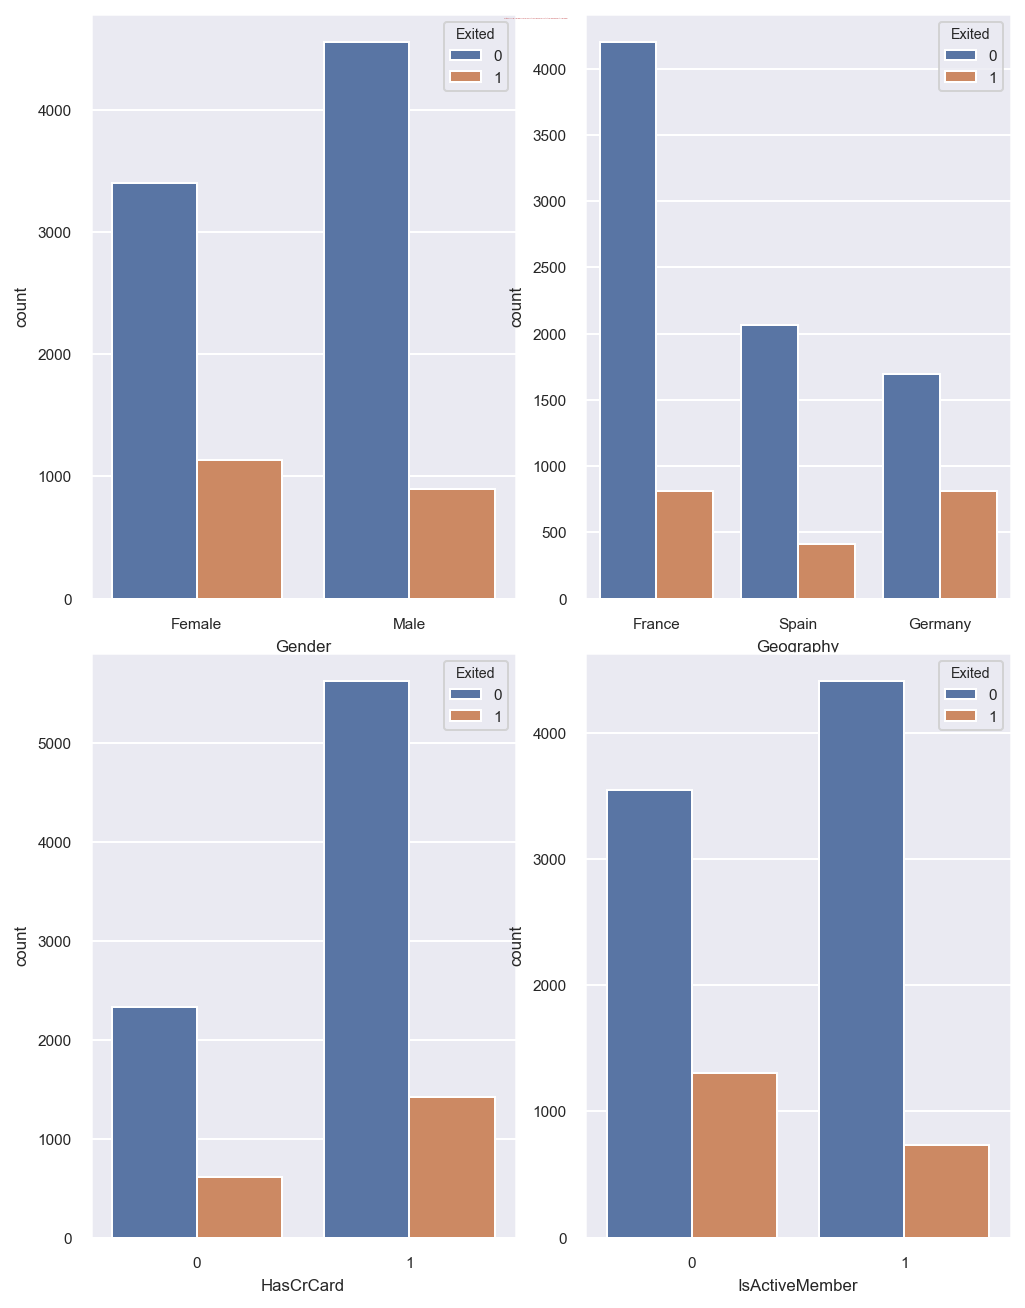

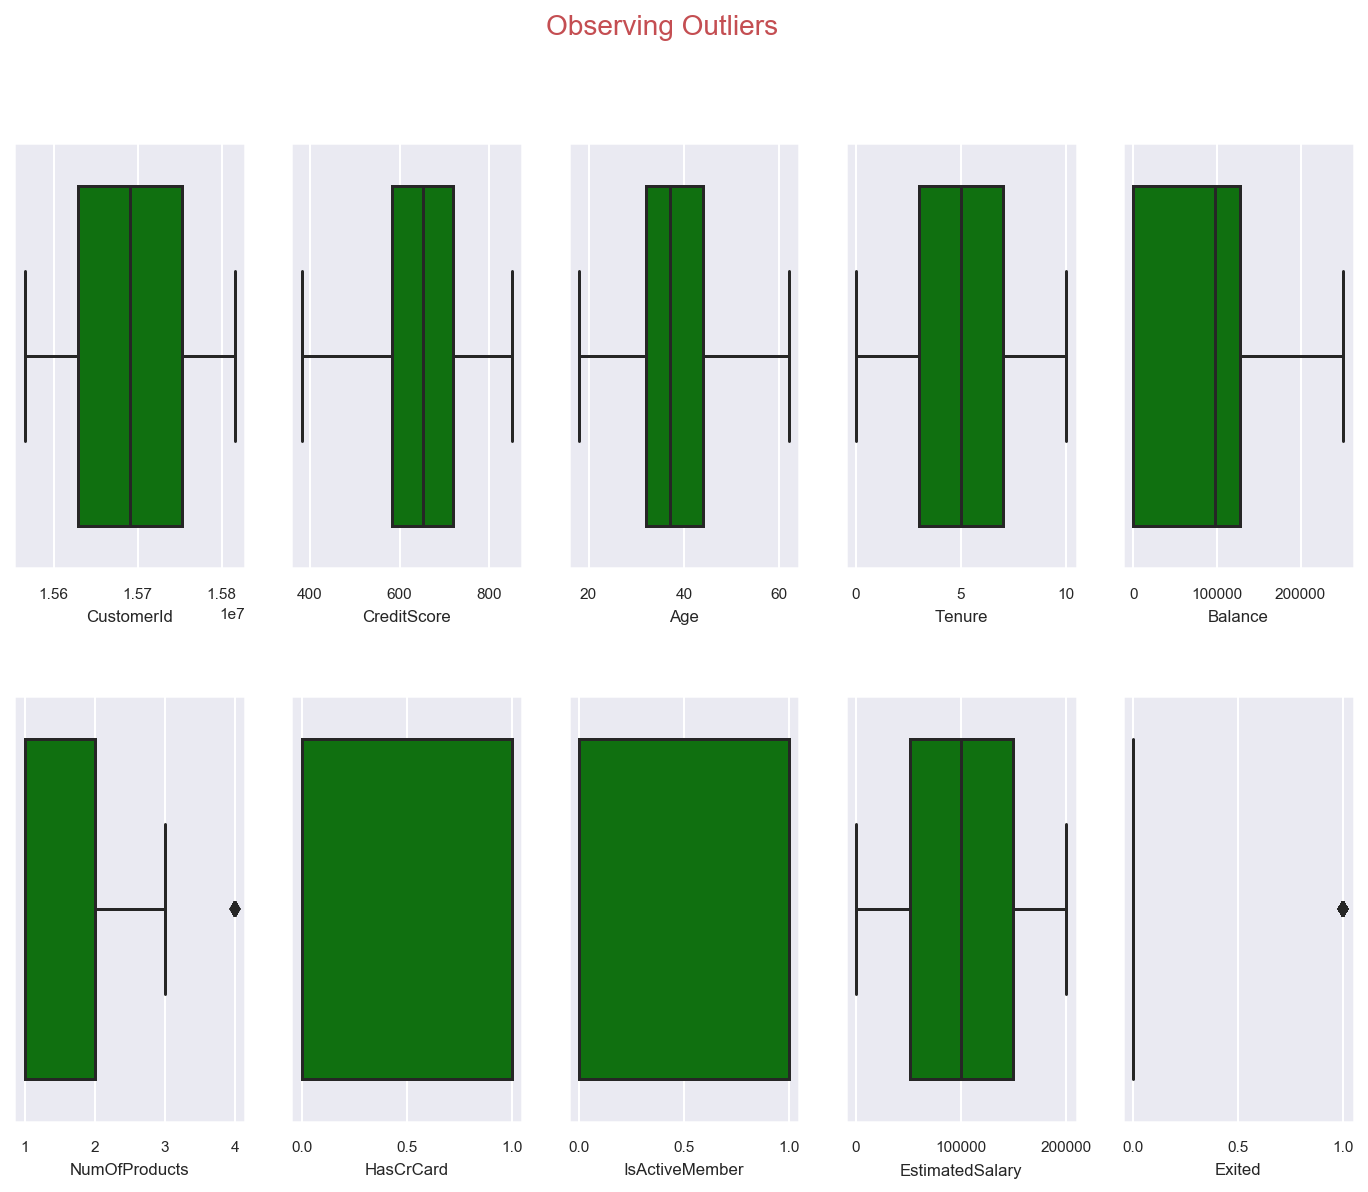

In [23]:
df_prep = data_prepare()

df_outlier = outlier_process(df = df_prep)


show_data_analysis(df_prep)
show_outliers(df = df_outlier)

Let's see after feature engineering:

In [24]:
df_fe = feature_engineering(df = df_outlier)
df_fe.head(3)

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,balance_salary_rate,product_utilization_rate_by_year,tenure_rate_by_age,credit_score_rate_by_age,credit_score_rate_by_salary,credit_score_table,countries_monthly_average_salaries
RowNumber,,,,,,,,,,,,,,,,,,,,
1,15634602,Hargrave,619.00,France,Female,42.00,2.00,0.00,1.00,1,1,101348.88,1,0.00,0.50,0.08,24.76,0.01,Fair,2.29
2,15647311,Hill,608.00,Spain,Female,41.00,1.00,83807.86,1.00,0,1,112542.58,0,0.74,1.00,0.04,25.33,0.01,Fair,4.16
3,15619304,Onio,502.00,France,Female,42.00,8.00,159660.80,3.00,1,0,113931.57,1,1.40,0.38,0.32,20.08,0.00,Poor,2.57


And see after data encoding:

In [25]:
df_encoded = data_encoding(df_fe)
df_encoded.drop(['credit_card_situation', 'is_active_member'], axis=1, inplace=True)
df_encoded.head(3)

,Age,Balance,Exited,balance_salary_rate,product_utilization_rate_by_year,tenure_rate_by_age,credit_score_rate_by_age,credit_score_rate_by_salary,countries_monthly_average_salaries,HasCrCard,IsActiveMember,NumOfProducts,Tenure,gender_category,country_category,credit_score_category
0,42.00,0.00,1,0.00,0.50,0.08,24.76,0.01,2.29,1,1,1.00,2.00,0,0,1
1,41.00,83807.86,0,0.74,1.00,0.04,25.33,0.01,4.16,0,1,1.00,1.00,0,2,1
2,42.00,159660.80,1,1.40,0.38,0.32,20.08,0.00,2.57,1,0,3.00,8.00,0,0,3


Now, let's see correlation graph:

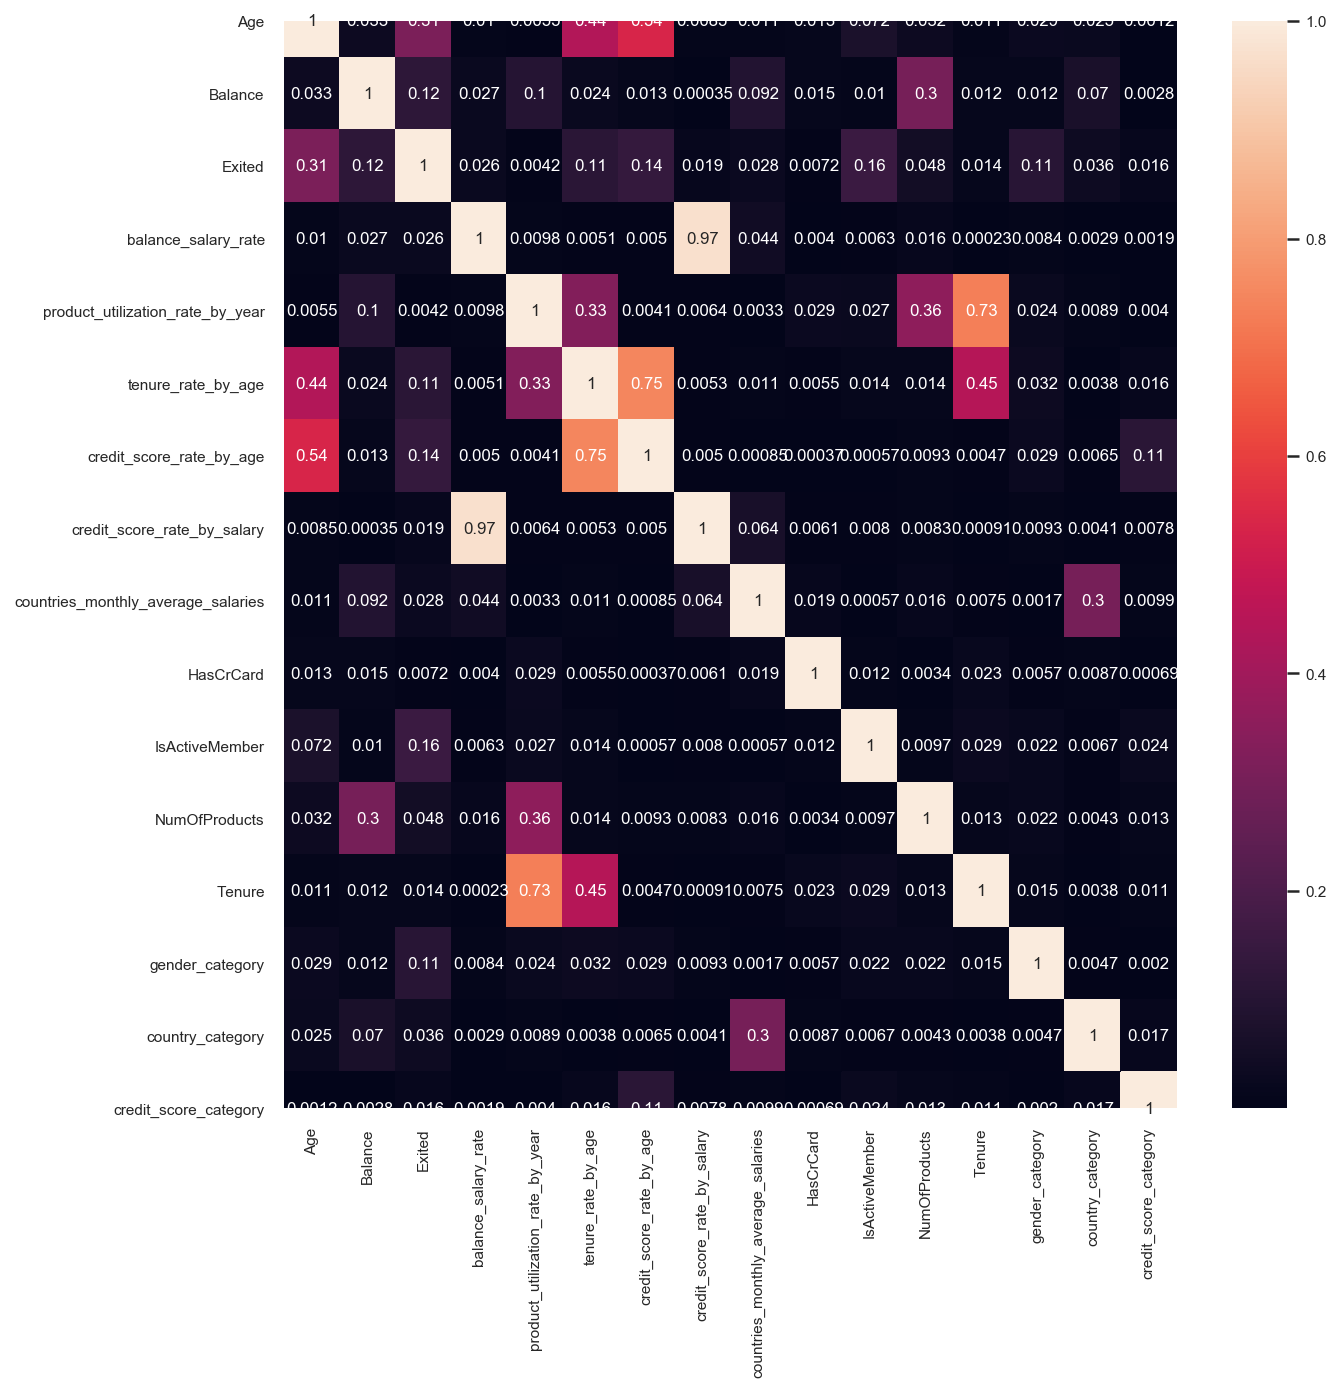

In [26]:
correlation = df_encoded.corr().abs()
plt.figure(figsize=(10,10))
sns.heatmap(correlation, annot=True)
plt.show()

List of correlation scores:

In [27]:
corrs_results = df_encoded.corrwith(df_encoded["Exited"]).abs().nlargest(24)
corrs_results

Exited                               1.00
Age                                  0.31
IsActiveMember                       0.16
credit_score_rate_by_age             0.14
Balance                              0.12
tenure_rate_by_age                   0.11
gender_category                      0.11
NumOfProducts                        0.05
country_category                     0.04
countries_monthly_average_salaries   0.03
balance_salary_rate                  0.03
credit_score_rate_by_salary          0.02
credit_score_category                0.02
Tenure                               0.01
HasCrCard                            0.01
product_utilization_rate_by_year     0.00
dtype: float64

## 8. Apply Model

In [28]:
# model_prepare test, train split 0.2
X_train, X_test, y_train, y_test = model_prepare(df_model = df_encoded)

### 8.1. Logistic Regression Model

Have a look with Logistic Regression.

In [29]:
logr_model = LogisticRegression().fit(X_train,y_train)
y_pred = logr_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(classification_report(y_test, y_pred, digits=4))
print("Accuracy score of Logistic Regression: ", accuracy)

              precision    recall  f1-score   support

           0     0.8212    0.9805    0.8938      1588
           1     0.7019    0.1772    0.2829       412

    accuracy                         0.8150      2000
   macro avg     0.7616    0.5788    0.5884      2000
weighted avg     0.7966    0.8150    0.7680      2000

Accuracy score of Logistic Regression:  0.815


### 8.2. Model Training

This is for all LogisticRegression, RandomForestClassifier, GradientBoostingClassifier, XGBClassifier, and LGBMClassifier model objects:

In [30]:
training_result = data_training(X_train, X_test, y_train, y_test)
training_result

Learning rate set to 0.030175
0:	learn: 0.6682692	total: 145ms	remaining: 2m 24s
1:	learn: 0.6451206	total: 151ms	remaining: 1m 15s
2:	learn: 0.6239426	total: 157ms	remaining: 52.3s
3:	learn: 0.6086981	total: 164ms	remaining: 40.9s
4:	learn: 0.5922312	total: 170ms	remaining: 33.9s
5:	learn: 0.5758206	total: 176ms	remaining: 29.2s
6:	learn: 0.5602977	total: 185ms	remaining: 26.2s
7:	learn: 0.5453307	total: 192ms	remaining: 23.8s
8:	learn: 0.5315944	total: 201ms	remaining: 22.1s
9:	learn: 0.5193123	total: 209ms	remaining: 20.7s
10:	learn: 0.5077253	total: 221ms	remaining: 19.8s
11:	learn: 0.4959540	total: 230ms	remaining: 18.9s
12:	learn: 0.4873040	total: 238ms	remaining: 18.1s
13:	learn: 0.4775600	total: 245ms	remaining: 17.2s
14:	learn: 0.4708440	total: 251ms	remaining: 16.5s
15:	learn: 0.4628943	total: 258ms	remaining: 15.9s
16:	learn: 0.4561013	total: 265ms	remaining: 15.3s
17:	learn: 0.4488242	total: 271ms	remaining: 14.8s
18:	learn: 0.4427898	total: 278ms	remaining: 14.4s
19:	learn

,model,accuracy_score,scale_method,0_precision,0_recall,1_precision,1_recall
6,LightGBM,0.87,NA,0.88,0.97,0.79,0.49
5,XGBoost,0.86,NA,0.87,0.97,0.79,0.44
4,GBM,0.86,NA,0.87,0.97,0.78,0.44
7,CatBoost,0.86,NA,0.87,0.96,0.75,0.47
3,RF,0.85,NA,0.86,0.96,0.73,0.42
1,KNN,0.84,NA,0.86,0.95,0.67,0.40
0,LOGR,0.81,NA,0.82,0.98,0.70,0.18
2,CART,0.78,NA,0.87,0.86,0.47,0.49


Now, let's have a look which model is best for us:

In [31]:
training_result

,model,accuracy_score,scale_method,0_precision,0_recall,1_precision,1_recall
6,LightGBM,0.87,NA,0.88,0.97,0.79,0.49
5,XGBoost,0.86,NA,0.87,0.97,0.79,0.44
4,GBM,0.86,NA,0.87,0.97,0.78,0.44
7,CatBoost,0.86,NA,0.87,0.96,0.75,0.47
3,RF,0.85,NA,0.86,0.96,0.73,0.42
1,KNN,0.84,NA,0.86,0.95,0.67,0.40
0,LOGR,0.81,NA,0.82,0.98,0.70,0.18
2,CART,0.78,NA,0.87,0.86,0.47,0.49


## 9. Model Tunning

### 9.1. XGBoost Tuning

In [32]:
xgb_model=XGBClassifier(silent=0, learning_rate=0.23, max_delta_step=5,
                            objective='reg:logistic',n_estimators=92, 
                            max_depth=5, eval_metric="logloss", gamma=3,base_score=0.5)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
print(classification_report(y_test,y_pred,digits=2))
print("Accuracy score of Tuned XGBoost Regression: ", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1588
           1       0.78      0.49      0.60       412

    accuracy                           0.87      2000
   macro avg       0.83      0.72      0.76      2000
weighted avg       0.86      0.87      0.85      2000

Accuracy score of Tuned XGBoost Regression:  0.8655


### 9.2. Random Forest Tuning

In [33]:
param_grid = {'max_depth': [3, 5, 6, 7, 8], 'max_features': [2,4,6,7,8,9],'n_estimators' : [50,100], 'min_samples_split': [3, 5, 6, 7]}
randFor_grid = GridSearchCV(RandomForestClassifier(), param_grid, cv = 5, refit = True, verbose = 0)
randFor_grid.fit(X_train,y_train)
best_model(randFor_grid)

0.8609478554457922
{'max_depth': 8, 'max_features': 8, 'min_samples_split': 6, 'n_estimators': 100}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=8, max_features=8, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=6,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


Using the parameters and get final version accuracy score.

In [40]:
rnd_model = RandomForestClassifier(max_depth=8, max_features=6, min_samples_split=6, n_estimators=50)
rnd_model.fit(X_train, y_train)
y_pred = rnd_model.predict(X_test)
print(classification_report(y_test,y_pred,digits=2))
print("Accuracy score of tuned Random Forest model: ", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1588
           1       0.81      0.42      0.56       412

    accuracy                           0.86      2000
   macro avg       0.84      0.70      0.74      2000
weighted avg       0.85      0.86      0.84      2000

Accuracy score of tuned Random Forest model:  0.8605


### 9.3. LightGBM Tuning

In [41]:
lgbm_model = LGBMClassifier(silent = 0, learning_rate = 0.09, max_delta_step = 2, n_estimators = 100, boosting_type = 'gbdt',
                            max_depth = 10, eval_metric = "logloss", gamma = 3, base_score = 0.5)
lgbm_model.fit(X_train, y_train)
y_pred = lgbm_model.predict(X_test)
print(classification_report(y_test, y_pred, digits=2))
print("Accuracy score of tuned LightGBM model: ", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1588
           1       0.79      0.49      0.61       412

    accuracy                           0.87      2000
   macro avg       0.83      0.73      0.76      2000
weighted avg       0.86      0.87      0.86      2000

Accuracy score of tuned LightGBM model:  0.868


## 10. Confussion Matrix

Confusion matrix, without normalization
[[1533   55]
 [ 209  203]]
True Negatives:  1533
False Positives:  55
False Negatives:  209
True Positives:  203


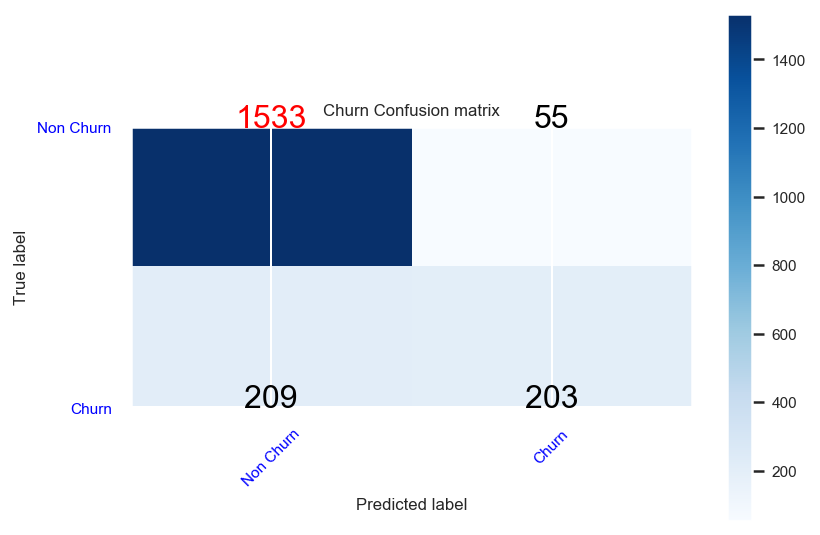

In [42]:
cfm = confusion_matrix(y_test, y_pred=y_pred)
plot_confusion_matrix(cfm, classes=['Non Churn','Churn'],
                      title='Churn Confusion matrix')


tn, fp, fn, tp = cfm.ravel()
print("True Negatives: ",tn)
print("False Positives: ",fp)
print("False Negatives: ",fn)
print("True Positives: ",tp)

In [43]:
#!pip install scikit-plot

## 11. ROC Curve

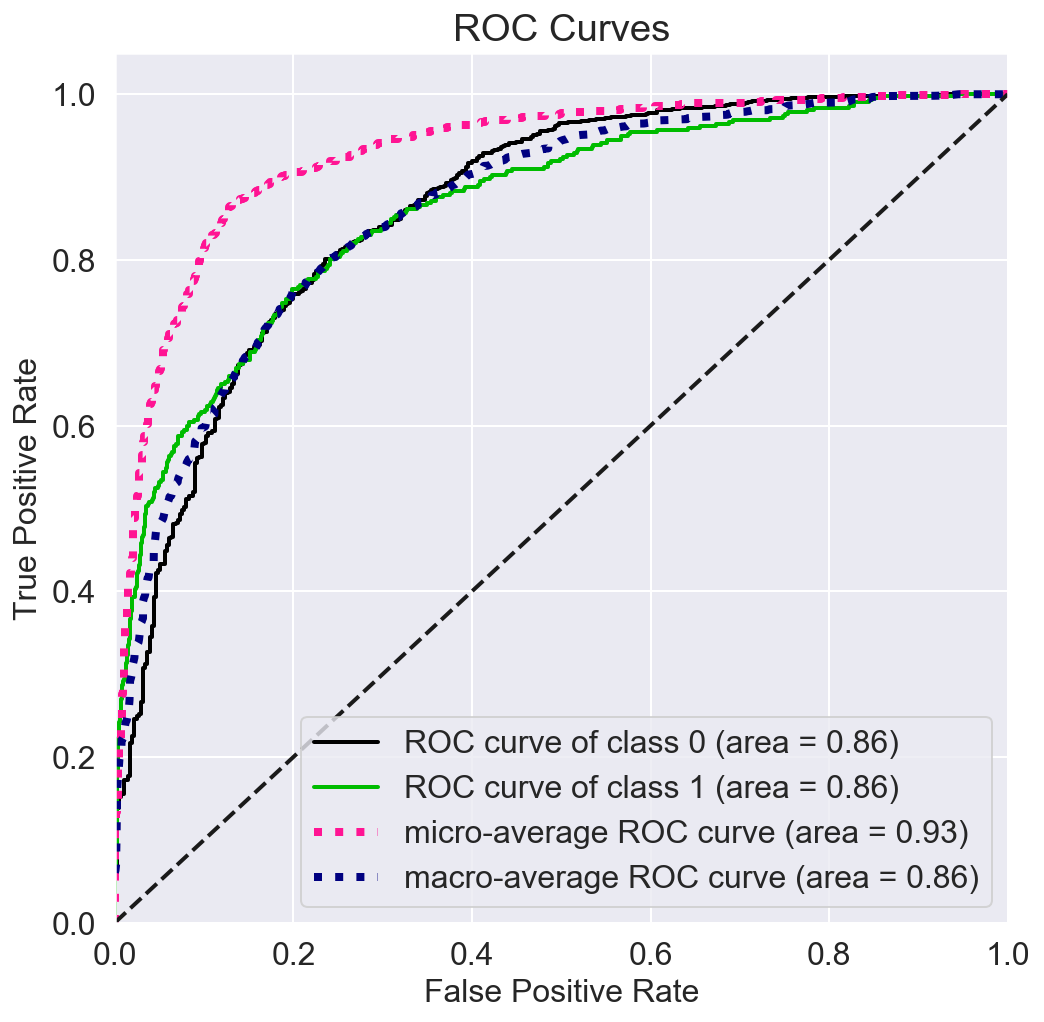

In [44]:
import scikitplot as skplt
y_pred_proba = lgbm_model.predict_proba(X_test)
skplt.metrics.plot_roc_curve(y_test, y_pred_proba, figsize=(8,8))

plt.show()

# 12. Feature Importance

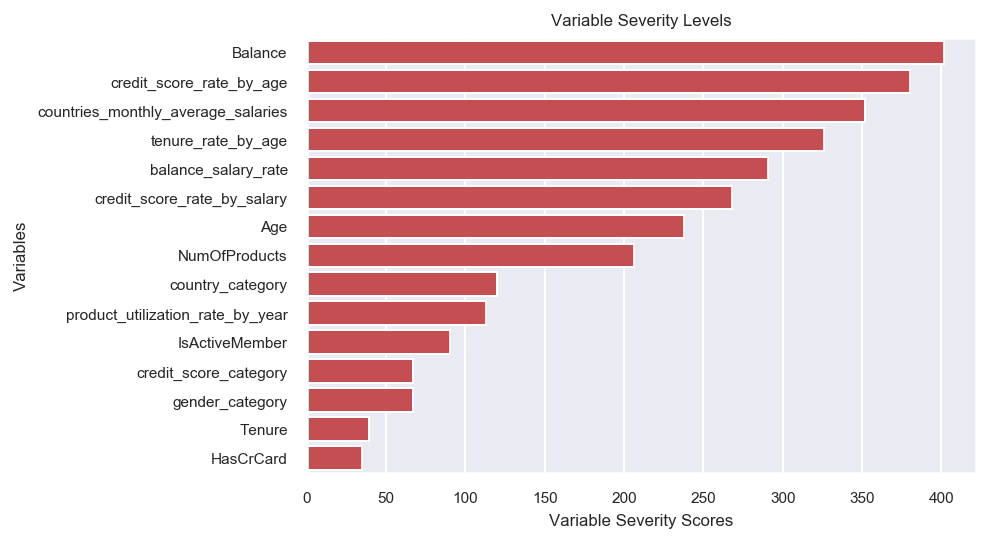

In [45]:
feature_index = df_encoded.loc[:, df_encoded.columns != dependent_variable_name]

feature_importance = pd.Series(lgbm_model.feature_importances_, 
                               index=feature_index.columns).sort_values(ascending=False)
sns.barplot(x = feature_importance, y = feature_importance.index, color='r', saturation=1)
plt.xlabel('Variable Severity Scores')
plt.ylabel('Variables')
plt.title('Variable Severity Levels')
plt.show()

# 13. Conclusion


- Our aim in this project was to develop a churn prediction model using machine learning algorithms.
- There were 10000 rows in the data set and there were no missing values. and the dataset consisted of 13 variables.


- The following conclusions came from the analysis on the features:

    * Most customers who using products 3 and 4 stopped working with the bank. In fact, all customers using product number 4 were gone.
    * Customers between the ages of 40 and 65 were more likely to quit the bank.
    * Those who had a credit score below 450 had high abandonment rates.
    * Predictions were made with a total of 8 classification models. The highest head was taken with LightGBM method.
    * Accuracy and cross validation scores were calculated for each model and results were displayed.



#### Note:

    * After this notebook, my aim is to prepare 'kernel' which is 'not clear' data set.

    * If you have any suggestions, please could you write for me? I wil be happy for comment and critics!

    * Thank you for your suggestion and votes ;)
